# iMaterialist 2020 Tutorial 
* refer to [here](https://www.kaggle.com/kaushal2896/imaterialist-2020-starter-eda-mask-rcnn)

In [120]:
import sys 
sys.path.append("./trainer/")
print(sys.path)

['/home/cvipl/CV2020-project_iMaterialist', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python37.zip', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/lib-dynload', '', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages', '/home/cvipl/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/IPython/extensions', '/home/cvipl/.ipython', './trainer/', './trainer/']


In [121]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import MultiStepLR

In [122]:
from PIL import Image, ImageFile
import numpy as np 
import os
import glob 
import matplotlib.pyplot as plt 
import pandas as pd 
import json
from pathlib import Path
import pycocotools

# Dataloader tutorial 
* [How to show PIL Image in ipython notebook](https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook)
* [Dataloader for semantic segmentation](https://discuss.pytorch.org/t/dataloader-for-semantic-segmentation/48290)

In [123]:
train_dir = "../imaterialist-fashion-2020-fgvc7/train"
img_files = glob.glob(os.path.join(train_dir, "*.jpg"))

In [124]:
idx = 0
pil_im = Image.open(img_files[idx])

file_name:  ../imaterialist-fashion-2020-fgvc7/train/4ce6ee014951ab6b3e44ba412d5a3072.jpg


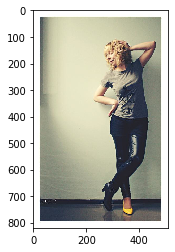

In [125]:
%matplotlib inline 
print("file_name: ", img_files[idx])
plt.imshow(np.asarray(pil_im))

# 1. Get Training and Validation Data Loader
* [iMaterialist Detectron2](https://www.kaggle.com/julienbeaulieu/imaterialist-detectron2)

In [126]:
data_dir = Path("../imaterialist-fashion-2020-fgvc7")
img_dir =  Path("../imaterialist-fashion-2020-fgvc7/train")
df = pd.read_csv(data_dir/"train.csv")

In [127]:
df.sample(5)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
268312,ce6d98223937ebf5df32c1f5b852901e,1906241 8 1908672 25 1911103 42 1913534 59 191...,2448,2448,31,"160,204"
225708,adbb4d56bac64b10b008efaf58bd2c29,2365519 2 2368698 5 2371876 9 2375051 17 23782...,3182,1500,34,NaN
51567,276cc06aceafbbcef559cd5c6598136e,6691666 5 6694803 15 6697941 24 6701078 34 670...,3148,4812,32,223
282133,d8f8d4c7ba03c8baed6cc4b5e86c7f44,1758680 1 1761678 3 1764675 7 1764721 2 176767...,3000,1997,29,174
129421,63b318d5a9e8bbd37b6459e7bcb9d49c,734215 5 734272 9 735811 16 735857 28 737355 2...,1600,1067,23,NaN


In [128]:
# _Start: to get label descriptions 
with open(data_dir/"label_descriptions.json", 'r') as file:
    label_desc = json.load(file)
# _End: to get label descriptions 

In [129]:
label_desc

{'categories': [{'id': 0,
   'name': 'shirt, blouse',
   'supercategory': 'upperbody',
   'level': 2},
  {'id': 1,
   'name': 'top, t-shirt, sweatshirt',
   'supercategory': 'upperbody',
   'level': 2},
  {'id': 2, 'name': 'sweater', 'supercategory': 'upperbody', 'level': 2},
  {'id': 3, 'name': 'cardigan', 'supercategory': 'upperbody', 'level': 2},
  {'id': 4, 'name': 'jacket', 'supercategory': 'upperbody', 'level': 2},
  {'id': 5, 'name': 'vest', 'supercategory': 'upperbody', 'level': 2},
  {'id': 6, 'name': 'pants', 'supercategory': 'lowerbody', 'level': 2},
  {'id': 7, 'name': 'shorts', 'supercategory': 'lowerbody', 'level': 2},
  {'id': 8, 'name': 'skirt', 'supercategory': 'lowerbody', 'level': 2},
  {'id': 9, 'name': 'coat', 'supercategory': 'wholebody', 'level': 2},
  {'id': 10, 'name': 'dress', 'supercategory': 'wholebody', 'level': 2},
  {'id': 11, 'name': 'jumpsuit', 'supercategory': 'wholebody', 'level': 2},
  {'id': 12, 'name': 'cape', 'supercategory': 'wholebody', 'level':

In [130]:
# _Start: Classes and Attributes processing 
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])
# _End: Classes and Attributes processing 

n_classes = len(label_desc['categories'])
n_attributes = len(label_desc['attributes'])

print('Classes: {0} \nAttributes: {1}'.
     format(str(n_classes), str(n_attributes)))

Classes: 46 
Attributes: 294


In [131]:
df_categories

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [132]:
df_attributes

,id,name,supercategory,level
0,0,classic (t-shirt),nickname,1
1,1,polo (shirt),nickname,1
2,2,undershirt,nickname,1
3,3,henley (shirt),nickname,1
4,4,ringer (t-shirt),nickname,1
...,...,...,...,...
289,336,peacock,animal,2
290,337,zebra,animal,2
291,338,giraffe,animal,2
292,339,toile de jouy,textile pattern,1


In [133]:
df_categories.supercategory.unique()

array(['upperbody', 'lowerbody', 'wholebody', 'head', 'neck',
       'arms and hands', 'waist', 'legs and feet', 'others',
       'garment parts', 'closures', 'decorations'], dtype=object)

In [134]:
df_attributes.supercategory.unique()

array(['nickname', 'silhouette', 'waistline', 'length', 'neckline type',
       'opening type', 'non-textile material type', 'leather',
       'textile finishing, manufacturing techniques', 'textile pattern',
       'animal'], dtype=object)

# Check out training images and their masks
* [iMaterialist - Segmentation task](https://www.kaggle.com/yanastamenova/imaterialist-segmentation-task)

In [135]:
# _Start: to get image lists 
size = 4 
img_ids = df["ImageId"].unique()[:size]
# _End: to get image lists 

images = [] 

for img in img_ids: 
    img_path = os.path.join(img_dir, img+".jpg")
    images.append(Image.open(img_path))


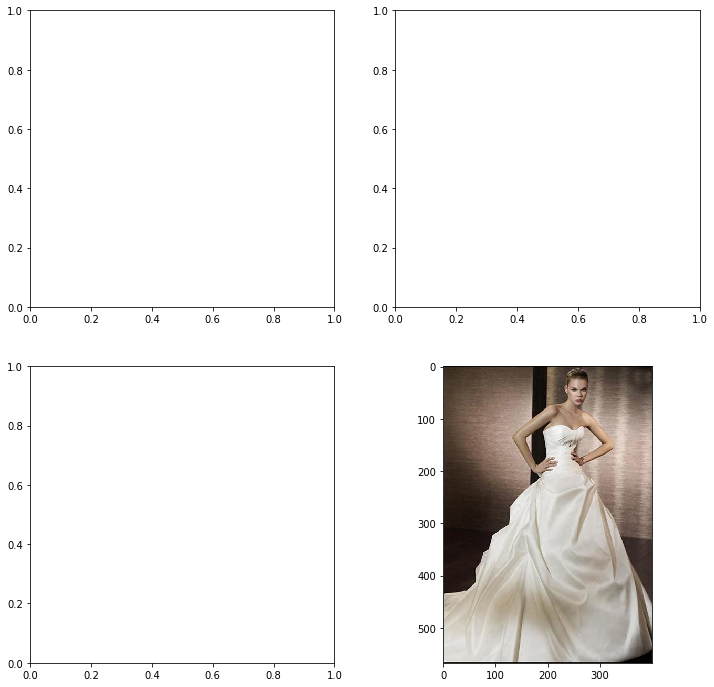

In [136]:
%matplotlib inline 
plt.rcParams["figure.figsize"] = (12, 12)
plt.figure 

plt.subplots(2,2)

for img in images: 
    
    img = np.asarray(img)
    plt.imshow(img)

plt.show()
    

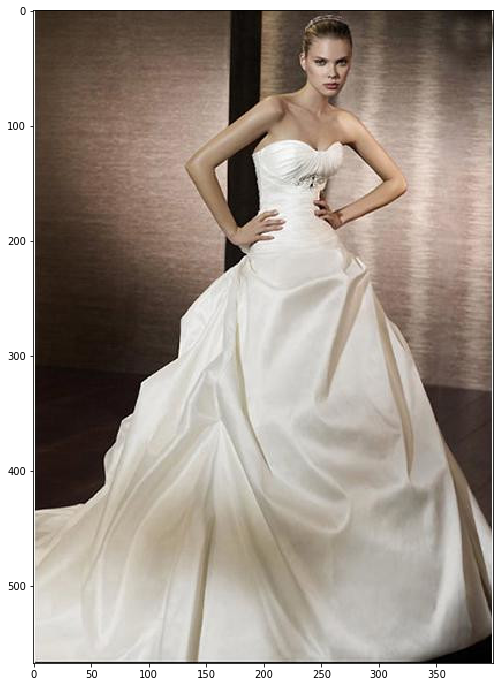

In [137]:
plt.imshow(np.asarray(images[3]))